In [1]:
import numpy as np
from numpy import pi as π
from numpy.fft import rfftfreq, rfft, irfft
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['font.size'] = 16

In [2]:
α = 1    # Thermal diffusivity constant
L = 100  # Length of domain
N = 1000 # Number of discretization points
dx = L / N
x = np.arange(-L/2, L/2, dx) # Define x domain

# Define discrete wavenumbers
κ = 2*π * rfftfreq(N, d=dx)

# Initial condition (Top Hat)
u0 = np.piecewise(
    x,
    [(-L/10 <= x) & (x <= L/10)],
    [1, 0]
)

# Initial condition in spatial frequency domain
û0 = rfft(u0)

# Simulate in spatial frequency domain
# Uses a view of complex as pairs of reals since odeint doesn't support complex

# Right hand side of Heat Equation in spatial frequency domain
def rhs_heat(û_f64, t, κ, α):
    û = û_f64.view(np.complex128)
    dû = -α**2 * κ**2 * û
    return dû.view(np.float64)

# Integrate in frequency domain
dt = 0.1
t = np.arange(0, 10, dt)
û = odeint(
    rhs_heat,
    û0.view(dtype=np.float64),
    t,
    args=(κ, α)
).view(np.complex128)

# Transform back spatial domain
u = irfft(û, axis=-1)

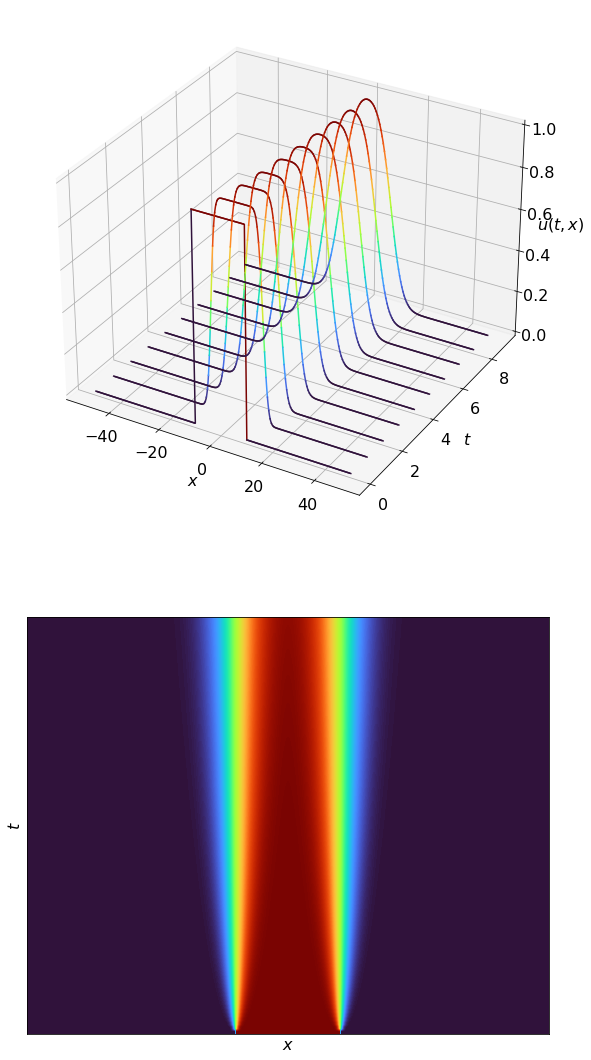

In [3]:
# Figure 2.14

def plot_coloured_line(ax, x, y, z, cmap=plt.cm.turbo, nsteps=200):
    z_normed = (z - z.min()) / (z.max() - z.min())
    step = len(z) // nsteps
    steps = np.arange(0, len(z), step)
    for start, stop in zip(steps[:-1], steps[1:]):
        ax.plot(
            x[start:stop+1],
            y[start:stop+1],
            z[start:stop+1],
            color=cmap(z_normed[(start+stop)//2])
        )

# Waterfall and image plots
fig = plt.figure(figsize=(8, 16))
axs = [
    fig.add_subplot(2, 1, 1, projection='3d'),
    fig.add_subplot(2, 1, 2)
]

u_plot = u[0:-1:10, :]
for j in range(u_plot.shape[0]):
    ys = j * np.ones(u_plot.shape[1])
    plot_coloured_line(axs[0], x, ys, u_plot[j, :])

axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$t$')
axs[0].zaxis.set_rotate_label(False)
axs[0].set_zlabel(r'$u(t, x)$', rotation=0)

axs[1].imshow(np.flipud(u), cmap='turbo', aspect=8)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$t$')
axs[1].axes.xaxis.set_ticks([])
axs[1].axes.yaxis.set_ticks([])
plt.tight_layout();